In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import math

In [2]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [3]:
len(set(train.userID) - set(test.userID)), len(set(test.userID) - set(train.userID)), len(set(test.userID) & set(train.userID))

(6698, 744, 0)

<AxesSubplot: >

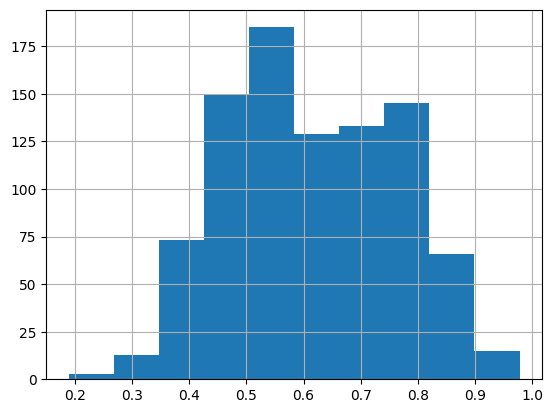

In [4]:
train.groupby('KnowledgeTag').answerCode.mean().sort_values().hist()

<AxesSubplot: >

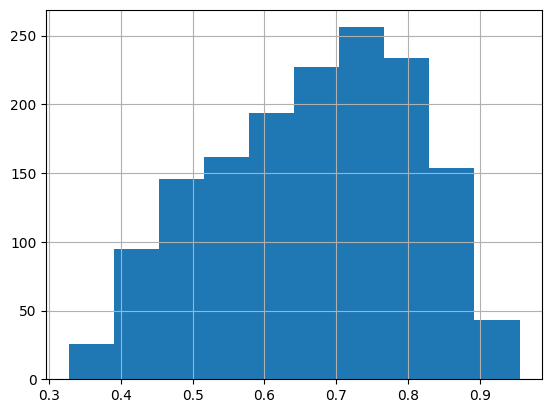

In [5]:
train.groupby('testId').answerCode.mean().sort_values().hist()

In [6]:
train['problem_n'] = train.assessmentItemID.apply(lambda x : int(x[-2:]))
test['problem_n'] = test.assessmentItemID.apply(lambda x : int(x[-2:]))

In [7]:
train['test_pre'] = train.testId.apply(lambda x : int(x[1:3]))
test['test_pre'] = test.testId.apply(lambda x : int(x[1:3]))

In [8]:
train['test_post'] = train.testId.apply(lambda x : int(x[-3:]))
test['test_post'] = test.testId.apply(lambda x : int(x[-3:]))

In [9]:
train.Timestamp = pd.to_datetime(train.Timestamp)
test.Timestamp = pd.to_datetime(test.Timestamp)

In [10]:
train['interval'] = 0
test['interval'] = 0

pre = ''
pre_time = pd.Timedelta(0)
for index, row in train.iterrows() :
    if pre != row['testId'] :
        pre = row['testId']
    else :
        train.loc[index, 'interval'] = row['Timestamp'] - pre_time
    pre_time = row['Timestamp']
    
pre = ''
pre_time = pd.Timedelta(0)
for index, row in test.iterrows() :
    if pre != row['testId'] :
        pre = row['testId']
    else :
        test.loc[index, 'interval'] = row['Timestamp'] - pre_time
    pre_time = row['Timestamp']
    
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_n,test_pre,test_post,interval
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,0 days 00:00:03
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,0 days 00:00:08
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,0 days 00:00:07
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,0 days 00:00:07


In [11]:
train['interval'] = train['interval'].apply(lambda x : x if type(x) is int else x.seconds)
test['interval'] = test['interval'].apply(lambda x : x if type(x) is int else x.seconds)
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_n,test_pre,test_post,interval
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,3
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,8
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,7


In [12]:
train.interval.describe()

count    2.266586e+06
mean     9.635674e+01
std      1.226732e+03
min      0.000000e+00
25%      3.000000e+00
50%      2.000000e+01
75%      5.400000e+01
max      8.615800e+04
Name: interval, dtype: float64

In [13]:
train['count'] = 0
train['correct'] = 0
train['tag_count'] = 0
train['tag_correct'] = 0
test['count'] = 0
test['correct'] = 0
test['tag_count'] = 0
test['tag_correct'] = 0

pre = ''
for index, value in train.iterrows() :
    if pre != value['userID'] :
        pre = value['userID']
        count = 0
        correct = 0
        count_dict = defaultdict(int)
        correct_dict = defaultdict(int)
    tag = value['KnowledgeTag']
    train.loc[index, 'count'] = count
    train.loc[index, 'correct'] = correct
    train.loc[index, 'tag_count'] = count_dict[tag]
    train.loc[index, 'tag_correct'] = correct_dict[tag]
    count += 1
    correct += value['answerCode']
    count_dict[tag] += 1
    correct_dict[tag] += value['answerCode']
    
pre = ''
for index, value in test.iterrows() :
    if pre != value['userID'] :
        pre = value['userID']
        count = 0
        correct = 0
        count_dict = defaultdict(int)
        correct_dict = defaultdict(int)
    tag = value['KnowledgeTag']
    test.loc[index, 'count'] = count
    test.loc[index, 'correct'] = correct
    test.loc[index, 'tag_count'] = count_dict[tag]
    test.loc[index, 'tag_correct'] = correct_dict[tag]
    count += 1
    correct += value['answerCode']
    count_dict[tag] += 1
    correct_dict[tag] += value['answerCode']
    
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_n,test_pre,test_post,interval,count,correct,tag_count,tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,0,0,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,3,1,1,0,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,8,2,2,1,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,3,3,2,2
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,7,4,4,3,3


In [14]:
train['rate'] = train[['count', 'correct']].apply(lambda x : x[1] / x[0] if x[0]>0 else 0, axis=1)
test['rate'] = test[['count', 'correct']].apply(lambda x : x[1] / x[0] if x[0]>0 else 0, axis=1)

train['tag_rate'] = train[['tag_count', 'tag_correct']].apply(lambda x : x[1] / x[0] if x[0]>0 else 0, axis=1)
test['tag_rate'] = test[['tag_count', 'tag_correct']].apply(lambda x : x[1] / x[0] if x[0]>0 else 0, axis=1)
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_n,test_pre,test_post,interval,count,correct,tag_count,tag_correct,rate,tag_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,0,0,0,0,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,3,1,1,0,0,1.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,8,2,2,1,1,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,3,3,2,2,1.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,7,4,4,3,3,1.0,1.0


In [15]:
mean = {i/10:[0, 0] for i in range(11)}
for i in range(11) :
    mean[i/10][0] += train[(train.tag_rate > 0.1*(i-1)) & (train.tag_rate <= 0.1*i)].answerCode.count()
    mean[i/10][1] += train[(train.tag_rate > 0.1*(i-1)) & (train.tag_rate <= 0.1*i)].answerCode.sum()
mean

{0.0: [681384, 374835],
 0.1: [2877, 633],
 0.2: [35375, 9533],
 0.3: [42693, 12865],
 0.4: [78971, 31787],
 0.5: [156416, 83516],
 0.6: [44857, 25948],
 0.7: [119534, 77549],
 0.8: [154923, 107396],
 0.9: [100235, 78436],
 1.0: [849321, 680707]}

In [16]:
data = {}
for key, value in mean.items() :
    data[key] = value[1] / value[0]
    #data.append(value[1] / value[0])
data

{0.0: 0.5501083089711528,
 0.1: 0.22002085505735142,
 0.2: 0.2694840989399293,
 0.3: 0.3013374557890052,
 0.4: 0.4025148472223981,
 0.5: 0.533935147299509,
 0.6: 0.5784604409568184,
 0.7: 0.6487610219686449,
 0.8: 0.6932217940525294,
 0.9: 0.7825210754726393,
 1.0: 0.8014719993971655}

In [17]:
train.head(20)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_n,test_pre,test_post,interval,count,correct,tag_count,tag_correct,rate,tag_rate
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,0,0,0,0,0,0.000000,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,3,1,1,0,0,1.000000,0.000000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,8,2,2,1,1,1.000000,1.000000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,3,3,2,2,1.000000,1.000000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,7,4,4,3,3,1.000000,1.000000
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,7,6,1,11,5,5,4,4,1.000000,1.000000
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,1,6,3,0,6,6,0,0,1.000000,0.000000
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,2,6,3,7,7,6,1,0,0.857143,0.000000
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,3,6,3,64,8,7,2,1,0.875000,0.500000
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,4,6,3,15,9,8,3,2,0.888889,0.666667


In [19]:
train['log_interval'] = train['interval'].apply(lambda x : math.log(x) if x > 0 else x)
train['pre_interval'] = train['interval'].apply(lambda x : 121 if x > 120 else x)
test['log_interval'] = test['interval'].apply(lambda x : math.log(x) if x > 0 else x)
test['pre_interval'] = test['interval'].apply(lambda x : 121 if x > 120 else x)

In [20]:
train.to_csv('pre_train_data.csv', index=False)
test.to_csv('pre_test_data.csv',index=False)

In [31]:
concat = pd.concat([train, test])
concat = concat[concat.answerCode >= 0]
concat.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,problem_n,test_pre,test_post,interval,count,correct,tag_count,tag_correct,rate,tag_rate,log_interval,pre_interval
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,0,0,0,0,0,0.0,0.0,0.000000,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,3,1,1,0,0,1.0,0.0,1.098612,3
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,8,2,2,1,1,1.0,1.0,2.079442,8
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,3,3,2,2,1.0,1.0,1.945910,7
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,7,4,4,3,3,1.0,1.0,1.945910,7


In [32]:
df_rate = pd.DataFrame(concat.groupby('userID').answerCode.mean().to_dict().items(), columns=['userID', 'mean_rate'])
df_interval_mean = pd.DataFrame(concat.groupby('userID').pre_interval.mean().to_dict().items(), columns=['userID', 'mean_interval'])
df_interval_std = pd.DataFrame(concat.groupby('userID').pre_interval.std().to_dict().items(), columns=['userID', 'std_interval'])
df_user = pd.merge(df_rate, df_interval_mean, on='userID')
df_user = pd.merge(df_user, df_interval_std, on='userID')
df_user.head()

,userID,mean_rate,mean_interval,std_interval
0,0,0.630872,29.144966,35.150413
1,1,0.853162,57.914255,45.374138
2,2,0.612319,34.572464,39.389410
3,3,0.692754,37.472464,38.509613
4,4,0.694030,45.816418,40.253131


In [33]:
df_rate = pd.DataFrame(concat.groupby('assessmentItemID').answerCode.mean().to_dict().items(), columns=['assessmentItemID', 'mean_p_rate'])
df_interval_mean = pd.DataFrame(concat.groupby('assessmentItemID').pre_interval.mean().to_dict().items(), columns=['assessmentItemID', 'mean_p_interval'])
df_interval_std = pd.DataFrame(concat.groupby('assessmentItemID').pre_interval.std().to_dict().items(), columns=['assessmentItemID', 'std_p_interval'])
df_problem = pd.merge(df_rate, df_interval_mean, on='assessmentItemID')
df_problem = pd.merge(df_problem, df_interval_std, on='assessmentItemID')
df_problem.head()

,assessmentItemID,mean_p_rate,mean_p_interval,std_p_interval
0,A010001001,0.922857,0.031429,0.587975
1,A010001002,0.960000,24.131429,20.136636
2,A010001003,0.905714,17.348571,17.126319
3,A010001004,0.945714,37.205714,28.434673
4,A010001005,0.882857,47.497143,30.071810


In [34]:
df_rate = pd.DataFrame(concat.groupby('KnowledgeTag').answerCode.mean().to_dict().items(), columns=['KnowledgeTag', 'mean_tag_rate'])
df_interval_mean = pd.DataFrame(concat.groupby('KnowledgeTag').pre_interval.mean().to_dict().items(), columns=['KnowledgeTag', 'mean_tag_interval'])
df_interval_std = pd.DataFrame(concat.groupby('KnowledgeTag').pre_interval.std().to_dict().items(), columns=['KnowledgeTag', 'std_tag_interval'])
df_tag = pd.merge(df_rate, df_interval_mean, on='KnowledgeTag')
df_tag = pd.merge(df_tag, df_interval_std, on='KnowledgeTag')
df_tag.head()

,KnowledgeTag,mean_tag_rate,mean_tag_interval,std_tag_interval
0,23,0.593000,40.344000,44.107600
1,24,0.625000,2.832500,16.661587
2,25,0.850000,40.170000,40.745095
3,26,0.611338,27.444609,38.728927
4,30,0.530000,23.883333,35.167803


In [25]:
df = pd.DataFrame(concat.groupby('assessmentItemID').interval.mean().to_dict().items(), columns=['assessmentItemID', 'mean_problem_interval'])
train = pd.merge(train, df, on='assessmentItemID')
test = pd.merge(test, df, on='assessmentItemID')

In [111]:
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,interval,tag_count,tag_correct,tag_ratio,problemNum,test_pre,test_post,mean_problem_rate,mean_problem_interval,log_interval,pre_interval,mean_rate,mean_interval
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0,0,0,0.0,1,6,1,0.984,73.144,0.000000,301,0.630872,43.530201
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,3,0,0,0.0,2,6,1,0.968,13.660,1.098612,3,0.630872,43.530201
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,8,1,1,1.0,3,6,1,0.916,26.112,2.079442,8,0.630872,43.530201
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,7,2,2,1.0,4,6,1,0.972,19.180,1.945910,7,0.630872,43.530201
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,7,3,3,1.0,5,6,1,0.948,18.076,1.945910,7,0.630872,43.530201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,6754,A050001003,A050000001,1,2020-01-20 13:31:08,2620,176,2,2,1.0,3,5,1,0.500,61.660,5.170484,176,0.703704,71.111111
2266582,6754,A050001004,A050000001,1,2020-01-20 13:33:09,2620,121,3,3,1.0,4,5,1,0.560,35.180,4.795791,121,0.703704,71.111111
2266583,6754,A050001005,A050000001,1,2020-01-20 13:38:01,2620,292,4,4,1.0,5,5,1,0.560,55.500,5.676754,292,0.703704,71.111111
2266584,6754,A050001006,A050000001,1,2020-01-20 13:39:20,2620,79,5,5,1.0,6,5,1,0.500,26.200,4.369448,79,0.703704,71.111111


In [110]:
train[['mean_problem_rate', 'mean_problem_interval']].apply(lambda x : x[0] + x[1])

mean_problem_rate         1.952
mean_problem_interval    86.804
dtype: float64

<AxesSubplot: xlabel='pre_interval'>

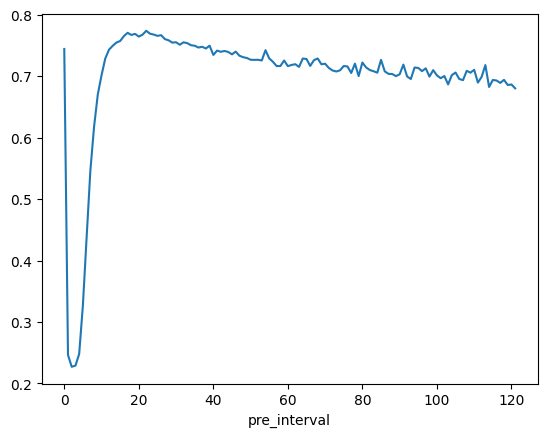

In [113]:
train.groupby('pre_interval').answerCode.mean().plot()

In [30]:
train.corr()

/tmp/ipykernel_89849/2189804198.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  train.corr()


,userID,answerCode,KnowledgeTag,interval,tag_count,tag_correct,tag_ratio,problemNum,test_pre,test_post,mean_problem_rate,mean_problem_interval,log_interval,pre_interval,mean_rate,mean_interval
userID,1.000000,-0.035235,-0.015064,-0.001693,-0.146839,-0.143149,-0.054388,-0.021852,-0.065891,0.179791,0.052678,-0.002131,-0.003704,-0.005204,-0.112844,-0.021836
answerCode,-0.035235,1.000000,0.012086,0.007207,-0.017581,0.131991,0.252647,-0.165713,-0.201841,0.058700,0.413354,-0.074190,0.126118,0.129432,0.312248,0.051677
KnowledgeTag,-0.015064,0.012086,1.000000,-0.001414,-0.001329,0.014204,-0.000128,0.012776,-0.150631,0.080247,0.030037,-0.014610,-0.011495,-0.006330,0.007620,-0.005268
interval,-0.001693,0.007207,-0.001414,1.000000,0.005680,0.010001,0.023202,-0.009030,0.008611,-0.002641,-0.017320,0.098225,0.195323,0.102991,0.012833,0.077544
tag_count,-0.146839,-0.017581,-0.001329,0.005680,1.000000,0.879949,0.282832,0.289182,-0.062931,-0.089169,-0.076029,-0.008911,0.153500,0.123201,0.072496,0.013338
tag_correct,-0.143149,0.131991,0.014204,0.010001,0.879949,1.000000,0.509696,0.223986,-0.166416,-0.048214,0.035778,-0.020366,0.236813,0.208918,0.229308,0.036984
tag_ratio,-0.054388,0.252647,-0.000128,0.023202,0.282832,0.509696,1.000000,0.185689,-0.230723,0.049556,0.117727,-0.004406,0.467995,0.398427,0.300430,0.045363
problemNum,-0.021852,-0.165713,0.012776,-0.009030,0.289182,0.223986,0.185689,1.000000,0.236791,-0.046904,-0.400008,-0.086987,0.316668,0.240643,-0.070878,0.018606
test_pre,-0.065891,-0.201841,-0.150631,0.008611,-0.062931,-0.166416,-0.230723,0.236791,1.000000,-0.206732,-0.486463,0.086813,-0.128744,-0.115554,-0.283952,0.057740
test_post,0.179791,0.058700,0.080247,-0.002641,-0.089169,-0.048214,0.049556,-0.046904,-0.206732,1.000000,0.140437,-0.024307,0.035387,0.025504,0.069262,-0.004970
